In [106]:
%load_ext autoreload
%autoreload 2
% matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [107]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tools import make_track, make_ER, ols_regression_PR, ols_regression, lasso_regression, ridge_regression
from hc_graph import hc_stock
sns.set()

In [108]:
prices = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU','BNPIFIT',
                            'BNPIFGE', 'BNPIFFR', 'BNPIFSP']]

prices_all = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]

returns = prices.resample("7D").first().pct_change().dropna()
returns_all = prices_all.resample("7D").first().pct_change().dropna()

In [140]:
sx5e = returns[["BNPIFEU"]]
bch = returns.drop("BNPIFEU", axis=1)
bch_all = returns_all.drop("BNPIFEU", axis=1)

size = 52
freq = 4
bounds = (-np.inf,np.inf)
total_weight = np.nan
l1 = 8e-5
l2 = 6e-5

df_weight = ols_regression(sx5e, bch, size, freq, boundaries=bounds, weight_sum=total_weight)
df_weight_all = ols_regression(sx5e, bch_all, size, freq, boundaries=bounds, weight_sum=total_weight)
df_weight_ridge = ridge_regression(sx5e, bch, size, freq, boundaries=bounds, weight_sum=total_weight, l=l1)
df_weight_ridge_all = ridge_regression(sx5e, bch_all, size, freq, boundaries=bounds, weight_sum=total_weight, l=l1)
df_weight_lasso = lasso_regression(sx5e, bch, size, freq, boundaries=bounds, weight_sum=total_weight, l=l2)
df_weight_lasso_all = lasso_regression(sx5e, bch_all, size, freq, boundaries=bounds, weight_sum=total_weight, l=l2)

In [141]:
prices_for_track = prices.loc[df_weight.index[0]:].drop("BNPIFEU", axis=1)
prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("BNPIFEU", axis=1)
replication = make_track(prices_for_track, df_weight)
replication_all = make_track(prices_for_track_all, df_weight_all)
replication_ridge = make_track(prices_for_track, df_weight_ridge)
replication_ridge_all = make_track(prices_for_track_all, df_weight_ridge_all)
replication_lasso = make_track(prices_for_track, df_weight_lasso)
replication_lasso_all = make_track(prices_for_track_all, df_weight_lasso_all)

df_res = prices.loc[replication.index][["BNPIFEU"]]
df_res["OLS"] = replication
df_res["OLS all"] = replication_all
df_res["Lasso"] = replication_lasso
df_res["Lasso all"] = replication_lasso_all
df_res["Ridge"] = replication_ridge
df_res["Ridge all"] = replication_ridge_all

df_res = df_res / df_res.iloc[0]

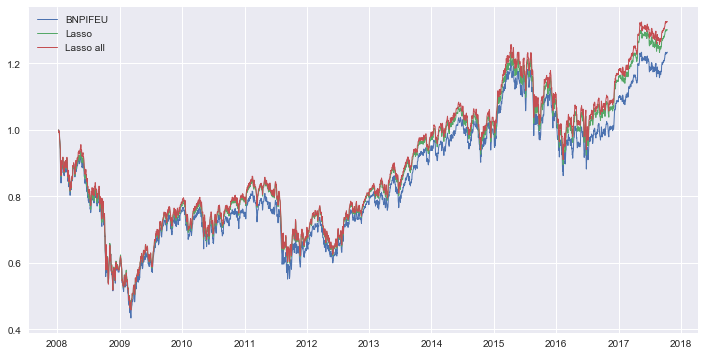

In [157]:
df_res[['BNPIFEU', 'Lasso', 'Lasso all']].plot(figsize=(12,6),linewidth=1)

In [158]:
df_res[['BNPIFEU', 'OLS', 'Lasso', 'Lasso all']].pct_change().corr(method="pearson")

,BNPIFEU,OLS,Lasso,Lasso all
BNPIFEU,1.000000,0.987185,0.986803,0.986411
OLS,0.987185,1.000000,0.999760,0.998908
Lasso,0.986803,0.999760,1.000000,0.999113
Lasso all,0.986411,0.998908,0.999113,1.000000


In [161]:
returns_track = df_res.pct_change().dropna()[['BNPIFEU', 'OLS', 'Lasso', 'Lasso all']]
feu = returns_track['BNPIFEU']
returns_track = returns_track.drop('BNPIFEU', axis=1)
df = pd.DataFrame()
df['Tracking error'] = (returns_track.T - feu.values).std(axis=1)
df

,Tracking error
OLS,0.002446
Lasso,0.002602
Lasso all,0.002651


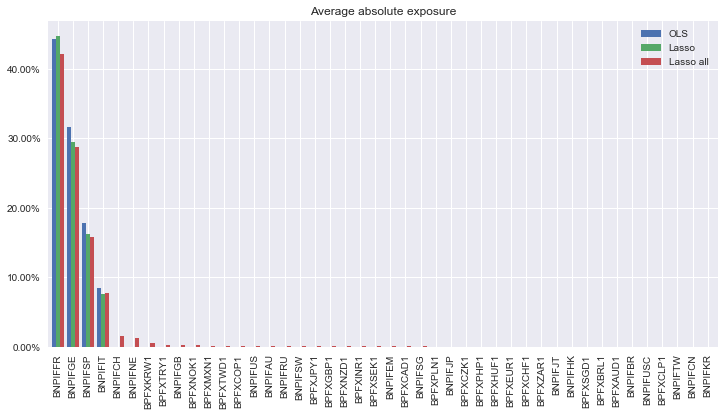

In [175]:
weight = pd.DataFrame(data={'Lasso all': np.abs(df_weight_lasso_all).mean(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', np.abs(df_weight).mean(axis=0))
weight.insert(1, 'OLS all', np.abs(df_weight_all).mean(axis=0))
weight.insert(2, 'Lasso', np.abs(df_weight_lasso).mean(axis=0))
weight['Ridge'] = np.abs(df_weight_ridge).mean(axis=0)
weight['Ridge all'] = np.abs(df_weight_ridge_all).mean(axis=0)
ax = weight[['OLS', 'Lasso', 'Lasso all']].plot(kind='bar', title='Average absolute exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

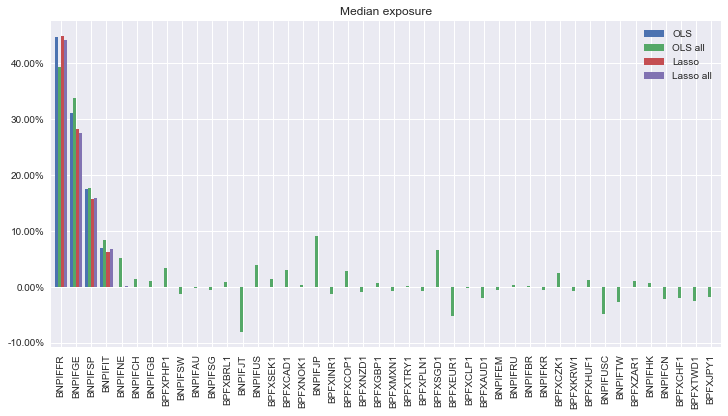

In [176]:
weight = pd.DataFrame(data={'Lasso all': (df_weight_lasso_all).median(axis=0).sort_values(ascending=False)})
weight.insert(0, 'OLS', (df_weight).median(axis=0))
weight.insert(1, 'OLS all', (df_weight_all).median(axis=0))
weight.insert(2, 'Lasso', (df_weight_lasso).median(axis=0))
weight['Ridge'] = (df_weight_ridge).median(axis=0)
weight['Ridge all'] = (df_weight_ridge_all).median(axis=0)
ax = weight[['OLS', 'OLS all', 'Lasso', 'Lasso all']].plot(kind='bar', title='Median exposure', figsize=(12, 6), width=0.8)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
plt.show()

In [170]:
weight.sum()

OLS          1.003230
OLS all      1.041472
Lasso        0.950390
Lasso all    0.945008
Ridge        0.956843
Ridge all    1.009195
dtype: float64